 # Plotting MCMC Chains generated with Firecrown

In this notebook, we plot the $9$ different chains generated with Firecrown and cosmosis. Let us discuss how the data was generated and how is the analysis done.

## Data

The data was generated with the NumCosmo library. We used the [Tinker08](https://arxiv.org/abs/0803.2706) mass function with critical overdensity $\Delta_c = 200$. We generated a catalog of clusters with a given mass, redshift and richness. We can use the mass function to generate clusters with a given a mass at a given redshift, but to generate its richness, we used the richness-mass relation described in [Murata et al](https://arxiv.org/abs/1707.01907). Explictly, the probability of a cluster with mass $M$ at redshift $z$ having a richness $ln \lambda$ is given by
$$$$
\begin{align}
P(\ln \lambda \mid M, z)=\frac{1}{\sqrt{2 \pi} \sigma_{\ln \lambda \mid M, z}} \exp \left(-\frac{x^2(\lambda, M, z)}{2 \sigma_{\ln \lambda \mid M, z}^2}\right),
\end{align}
$$$$
such that
$$$$
\begin{align}
\begin{aligned}
x(\lambda, M, z) & \equiv \ln \lambda-\left[A+B \ln \left(\frac{M}{M_{\text {pivot }}}\right)\right. \\
& \left.+B_z \ln \left(\frac{1+z}{1+z_{\text {pivot }}}\right)\right] .
\end{aligned}
\end{align}
$$$$
and
$$$$
\begin{align}
\begin{aligned}
\sigma_{\ln N \mid M, z} & =\sigma_0+q \ln \left(\frac{M}{M_{\mathrm{pivot}}}\right) \\
& +q_z \ln \left(\frac{1+z}{1+z_{\mathrm{pivot}}}\right)
\end{aligned}
\end{align}
.$$$$

Besides the mass function and the richness-mass relation, we also needed to define an sky area where we are going to generate our data and a covariance computed from the data. These informations can be found on the data generation files for each analysis.

## Model

We want to use cluster counts and the mean mass inside each bin to probe cosmology and constrain the richness-mass relation. Thus we need to compute the theory predictions of these quantities, which are respectively given by
$$$$
\begin{align}
N_{\alpha\beta}^{\rm predicted} = \Omega_s\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\log_{10}M_{min}}^{\log_{10}M_{max}}\int_{\log_{10}\lambda_{\beta }}^{\log_{10}\lambda_{\beta +1}}\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}P(\ln \lambda \mid M, z)d\log_{10}Md\log_{10}\lambda
,\end{align}
$$$$
and 
$$$$
\begin{align}
\left<M\right>_{\alpha\beta}^{\rm predicted} = \frac{1}{N_{\alpha\beta}^{\rm predicted}}\Omega_s\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\log_{10}M_{min}}^{\log_{10}M_{max}}\int_{\log_{10}\lambda_{\beta }}^{\log_{10}\lambda_{\beta +1}}\frac{d^2V(z)}{dz d\Omega}log_{10}M\frac{dn(M,z)}{d\log_{10}M}P(\ln \lambda \mid M, z)d\log_{10}Md\log_{10}\lambda
,\end{align}
$$$$
such that $\frac{dn(M,z)}{d\log_{10}M}$ is the mass function, $\alpha$ and $\beta$ represent the bins, $\frac{d^2V(z)}{dz d\Omega}$ is the volume element and $\Omega_s$ is the sky area of the survey.

Once we have computed the theoritical prediction, we build a Gaussian likelihood between the data and the prediction quantities, using a data driven convariace. Let us now read the chains generated for each analysis.


In [ ]:
import pandas as pd
from getdist import plots
from getdist import MCSamples
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cosmosis.postprocess import parser
from cosmosis.postprocessing.inputs import read_input
from cosmosis.postprocessing.postprocess import postprocessor_for_sampler
from cosmosis.postprocessing.plots import (
    MetropolisHastingsPlots2D,
    MetropolisHastingsPlots1D,
)

import os
import corner
from chainconsumer import ChainConsumer
import matplotlib.pyplot as plt
from IPython.display import display, Math

First we read the chains using cosmosis postprocessing

In [ ]:
cosmo_both = read_input(
    "/pbs/home/e/ebarroso/firecrown/examples/mean_mass_tests/Fitt_cosmology/both/output/number_counts_samples.txt"
)
cosmo_mass = read_input(
    "/pbs/home/e/ebarroso/firecrown/examples/mean_mass_tests/Fitt_cosmology/mean_mass/output/number_counts_samples.txt"
)
cosmo_rich = read_input(
    "/pbs/home/e/ebarroso/firecrown/examples/mean_mass_tests/Fitt_cosmology/richness/output/number_counts_samples.txt"
)
rich_both = read_input(
    "/pbs/home/e/ebarroso/firecrown/examples/mean_mass_tests/Fitt_Richness/both/output/number_counts_samples.txt"
)
rich_mass = read_input(
    "/pbs/home/e/ebarroso/firecrown/examples/mean_mass_tests/Fitt_Richness/mean_mass/output/number_counts_samples.txt"
)
rich_rich = read_input(
    "/pbs/home/e/ebarroso/firecrown/examples/mean_mass_tests/Fitt_Richness/richness/output/number_counts_samples.txt"
)
both_both = read_input(
    "/pbs/home/e/ebarroso/firecrown/examples/mean_mass_tests/Fitt_Both/both/output/number_counts_samples.txt"
)
both_mass = read_input(
    "/pbs/home/e/ebarroso/firecrown/examples/mean_mass_tests/Fitt_Both/mean_mass/output/number_counts_samples.txt"
)
both_rich = read_input(
    "/pbs/home/e/ebarroso/firecrown/examples/mean_mass_tests/Fitt_Both/richness/output/number_counts_samples.txt"
)

Here, we only take the parts of the output file that we are interested in.

In [3]:
data_cb = []
for line in cosmo_both[1]["data"][1][0]:
    data_cb.append([line[0], line[1]])

data_cm = []
for line in cosmo_mass[1]["data"][1][0]:
    data_cm.append([line[0], line[1]])

data_cr = []
for line in cosmo_rich[1]["data"][1][0]:
    data_cr.append([line[0], line[1]])


## First Case: Fitting Cosmology parameters

In this case, we use the true values of the richness-proxy relation to try to fit only the cosmological parameters. We have three different cases:
    
    - Using just the mean mass inside each bin of redshift and richness (since this is a mock catalog, we know the true mean mass of the data).
    - Using just the counts inside each bin of redshift and richness.
    - Using both informations.

In [20]:
names = [
    '1',
    '2',
]
labels = [r"\Omega_m", r"\sigma_8"]
settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples1 = MCSamples(samples=np.array(data_cb), names=names, labels=labels, settings=settings)
samples2 = MCSamples(samples=np.array(data_cm), names=names, labels=labels, settings=settings)
samples3 = MCSamples(
    samples=np.array(data_cr),
    names=names,
    labels=labels,
    settings=settings,
)
samples1.removeBurn(0.3)
samples2.removeBurn(0.3)
samples3.removeBurn(0.3)


Removed no burn in
Removed no burn in
Removed no burn in


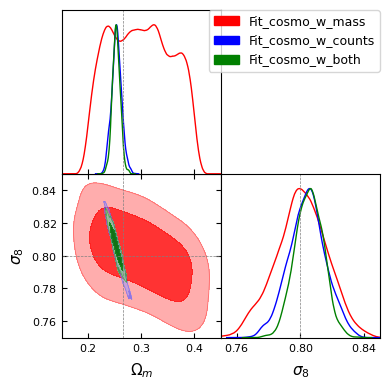


 The best fit for the three cases are: 


 Using data from mean mass only 



<IPython.core.display.Math object>

<IPython.core.display.Math object>


 Using data from counts only 



<IPython.core.display.Math object>

<IPython.core.display.Math object>


 Using data from both 



<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [30]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot(
    [samples2, samples3, samples1],
    filled=True,
    alphas=[0.8,0.55],
    contour_ls="-",
    contour_lws=1,
    fine_bins=1,
    colors=['red','blue', 'green'],
    line_args=[{'lw':1.2,'ls':'-', 'color':'red'},{'lw':1.2,'ls':'-', 'color':'blue'},{'lw':1.2,'ls':'-', 'color':'green'}],
    marker_args={"linewidth": 4},
    markers={"1": 0.26448, "2": 0.800},
    legend_labels=["Fit_cosmo_w_mass", "Fit_cosmo_w_counts", "Fit_cosmo_w_both"],
    param_limits={'1': [0.15, 0.45],
                '2' : [.75, 0.85]},
)

plt.show()

print("\n The best fit for the three cases are: \n")
print("\n Using data from mean mass only \n")

display(Math(samples2.getInlineLatex('1',limit=1)))
display(Math(samples2.getInlineLatex('2',limit=1)))
print("\n Using data from counts only \n")
display(Math(samples3.getInlineLatex('1',limit=1)))
display(Math(samples3.getInlineLatex('2',limit=1)))
print("\n Using data from both \n")
display(Math(samples1.getInlineLatex('1',limit=1)))
display(Math(samples1.getInlineLatex('2',limit=1)))

## Second Case: Fitting Richness-mass relation parameters

In this case, we use the true values of the cosmology and try to fit only the 6 richness-proxy relation parameters. We have three different cases:
    
    - Using just the mean mass inside each bin of redshift and richness (since this is a mock catalog, we know the true mean mass of the data).
    - Using just the counts inside each bin of redshift and richness.
    - Using both informations.

In [6]:
data_rb = []
for line in rich_both[1]["data"][1][0]:
    data_rb.append([line[0], line[1], line[2], line[3], line[4], line[5]])

data_rm = []
for line in rich_mass[1]["data"][1][0]:
    data_rm.append([line[0], line[1], line[2], line[3], line[4], line[5]])

data_rr = []
for line in rich_rich[1]["data"][1][0]:
    data_rr.append([line[0], line[1], line[2], line[3], line[4], line[5]])
    


Removed no burn in
Removed no burn in
Removed no burn in


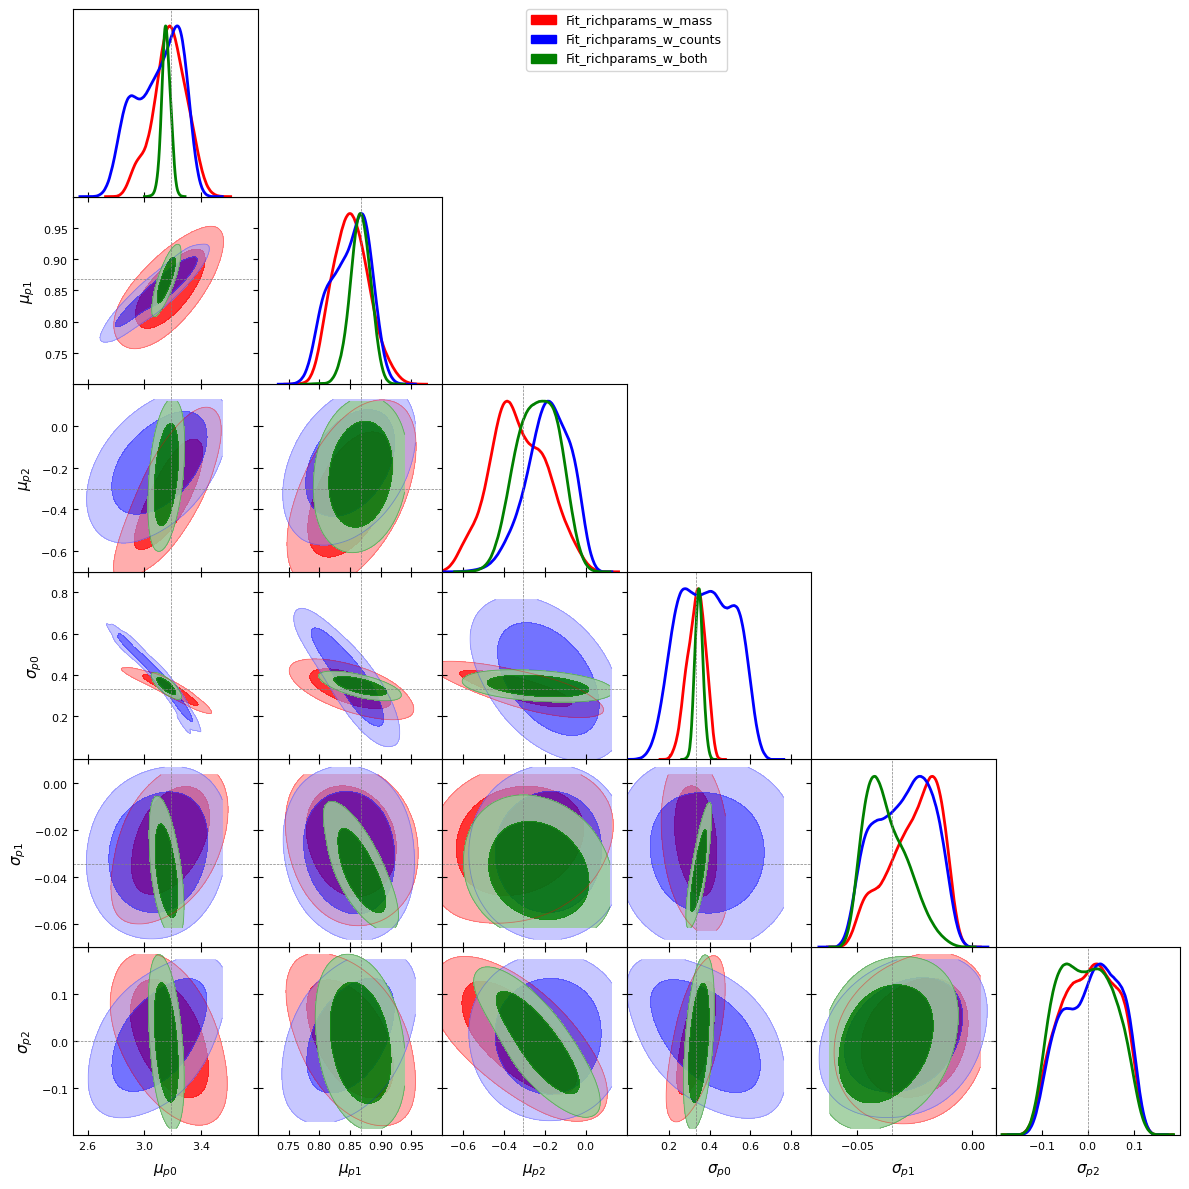


 The best fit for the three cases are: 


 Using data from mean mass only 



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


 Using data from counts only 



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


 Using data from both 



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [40]:
# Triangle plot
names = [
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
]
labels = [r"\mu_{p0}", r"\mu_{p1}", r"\mu_{p2}", r"\sigma_{p0}", r"\sigma_{p1}", r"\sigma_{p2}"]
settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 8,
    "smooth_scale_1D": 6,
    "boundary_correction_order": 0,
}



samples4 = MCSamples(
    samples=np.array(data_rb),
    names=names,
    labels=labels,
    settings=settings,
)
samples5 = MCSamples(
    samples=np.array(data_rm),
    names=names,
    labels=labels,
    settings=settings,
)
samples6 = MCSamples(
    samples=np.array(data_rr),
    names=names,
    labels=labels,
    settings=settings,
)
samples4.removeBurn(0.3)
samples5.removeBurn(0.3)
samples6.removeBurn(0.3)

g = plots.get_subplot_plotter()
g.triangle_plot(
    [samples5, samples6, samples4],
    filled=[True,True,True],
    alphas=[0.8,0.55],
    colors=['red','blue', 'green'],
    contour_ls="-",
    contour_lws=2,
    fine_bins=1,
    marker_args={"linewidth": 4},
    line_args=[{'lw':1.2,'ls':'-', 'color':'red'},{'lw':1.2,'ls':'-', 'color':'blue'},{'lw':1.2,'ls':'-', 'color':'green'}],
    markers={"1": 3.19, "2": 0.8685889638,"3":  -0.30400613733, "4": 0.33,"5": -0.0347435585, "6": 0.0},
    legend_labels=["Fit_richparams_w_mass", "Fit_richparams_w_counts", "Fit_richparams_w_both"],
        param_limits={'1': [2.5, 3.8],
                '2' : [.7, 1.], 
                     '3':[-.7, 0.2],
                     '4':[-0.01, 0.9],
                     '5':[-.07, 0.01],
                     '6':[-.2, 0.2],},
                
)

plt.show()
print("\n The best fit for the three cases are: \n")
print("\n Using data from mean mass only \n")
for item in range(1,7):
    display(Math(samples5.getInlineLatex(f'{item}',limit=2)))
print("\n Using data from counts only \n")
for item in range(1,7):
    display(Math(samples6.getInlineLatex(f'{item}',limit=2)))
print("\n Using data from both \n")
for item in range(1,7):
    display(Math(samples4.getInlineLatex(f'{item}',limit=2)))

## Third Case: Fitting both the cosmology and the Richness-mass relation parameters

In this case, we try to fit all the 8 parameters at once (2 from cosmology and 6 richness-proxy relation parameters). We have three different cases:
    
    - Using just the mean mass inside each bin of redshift and richness (since this is a mock catalog, we know the true mean mass of the data).
    - Using just the counts inside each bin of redshift and richness.
    - Using both informations.

In [8]:
data_bb = []
for line in both_both[1]["data"][1][0]:
    data_bb.append([line[0], line[1], line[2], line[3], line[4], line[5], line[6], line[7]])

data_bm = []
for line in both_mass[1]["data"][1][0]:
    data_bm.append([line[0], line[1], line[2], line[3], line[4], line[5], line[6], line[7]])

data_br = []
for line in both_rich[1]["data"][1][0]:
    data_br.append([line[0], line[1], line[2], line[3], line[4], line[5], line[6], line[7]])
    


Removed no burn in
Removed no burn in
Removed no burn in


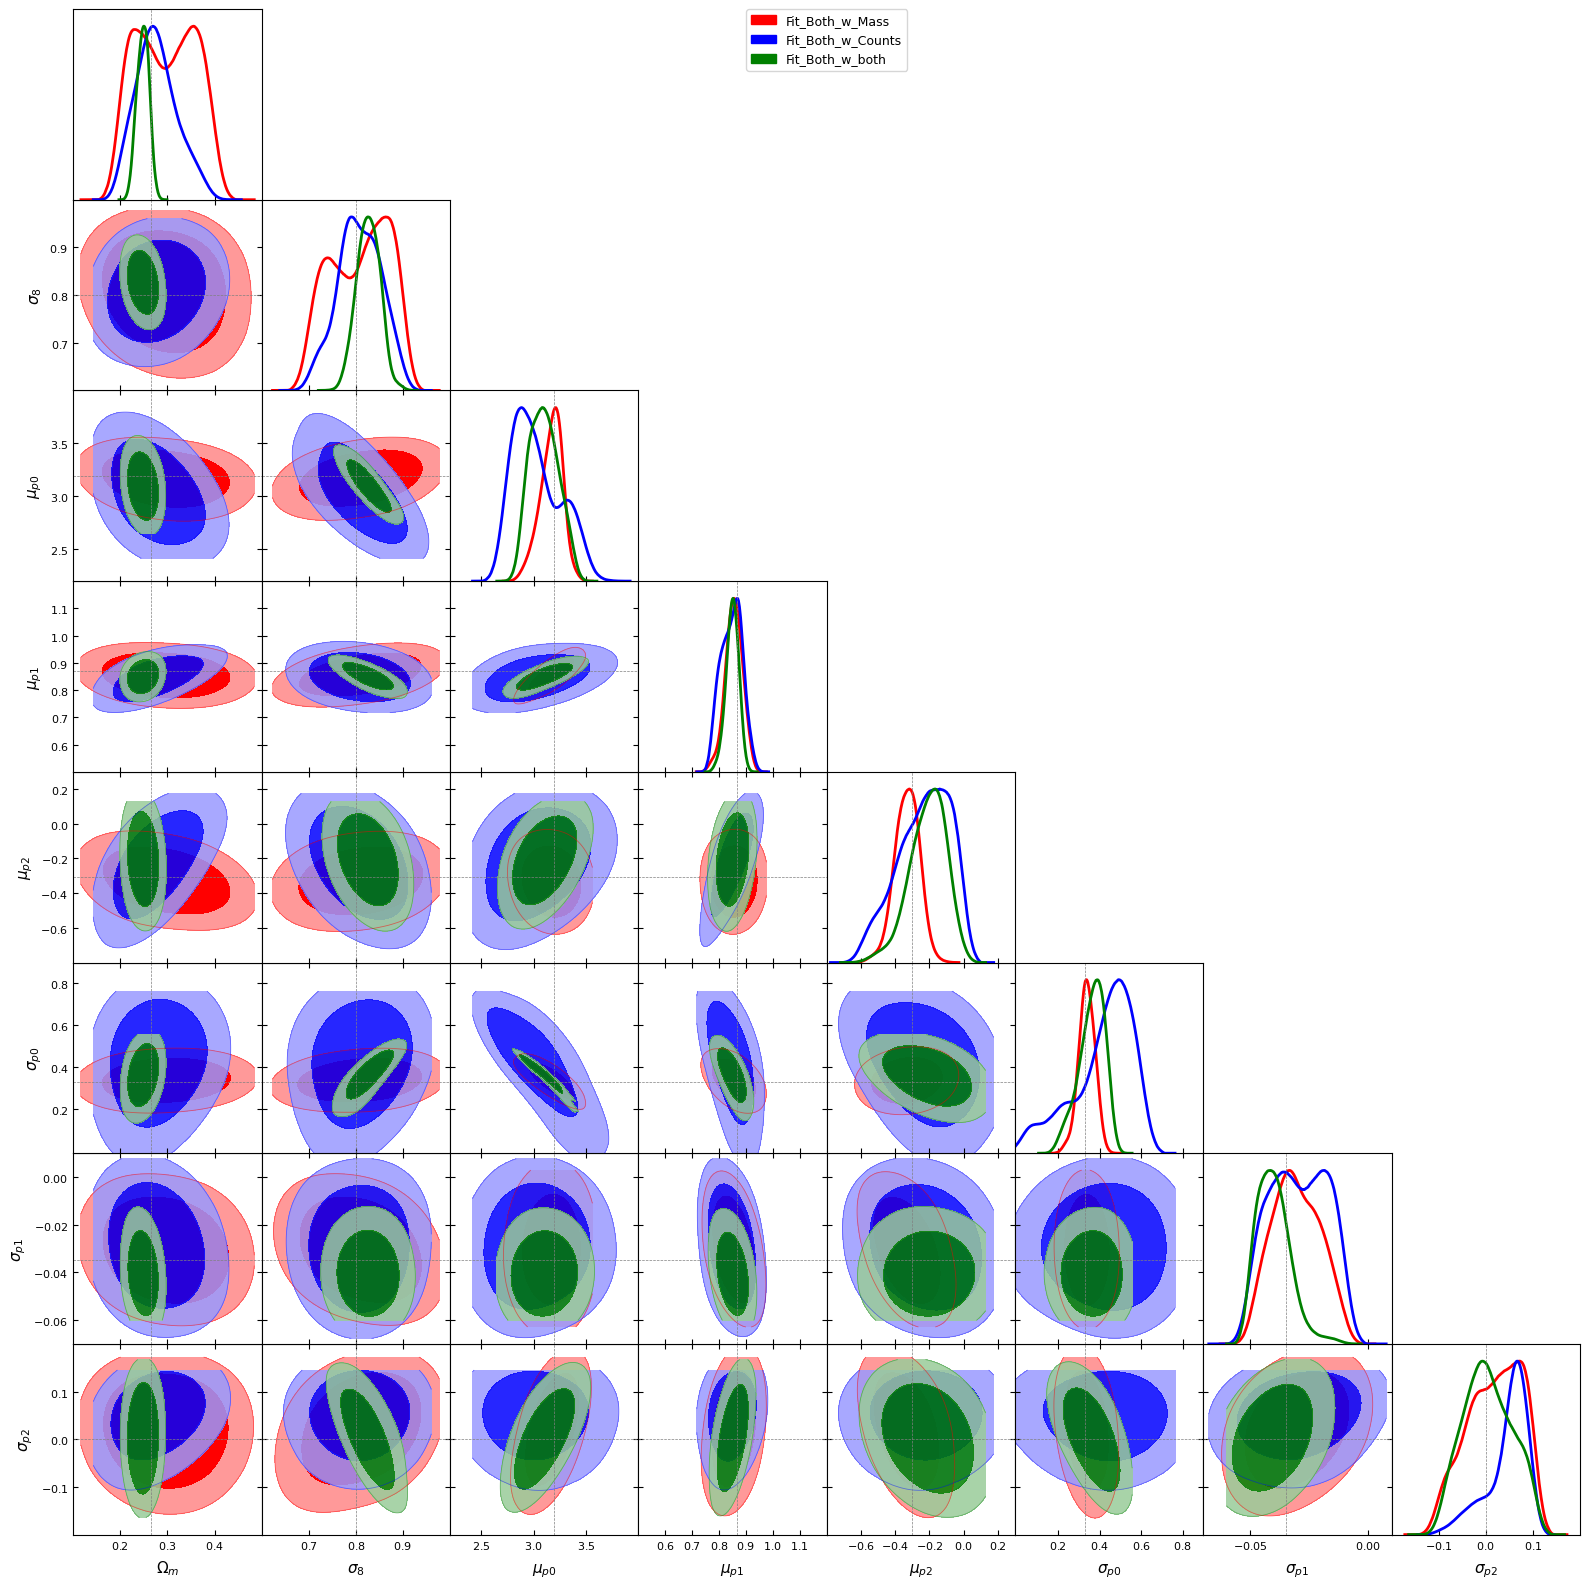


 The best fit for the three cases are: 


 Using data from mean mass only 



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


 Using data from counts only 



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


 Using data from both 



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [42]:
# Triangle plot
names = [
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
]
labels = [r"\Omega_m", r"\sigma_8",r"\mu_{p0}", r"\mu_{p1}", r"\mu_{p2}", r"\sigma_{p0}", r"\sigma_{p1}", r"\sigma_{p2}"]
settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 8,
    "smooth_scale_1D": 6,
    "boundary_correction_order": 0,
}



samples7 = MCSamples(
    samples=np.array(data_bb),
    names=names,
    labels=labels,
    settings=settings,
)
samples8 = MCSamples(
    samples=np.array(data_bm),
    names=names,
    labels=labels,
    settings=settings,
)
samples9 = MCSamples(
    samples=np.array(data_br),
    names=names,
    labels=labels,
    settings=settings,
)
samples7.removeBurn(0.3)
samples8.removeBurn(0.3)
samples9.removeBurn(0.3)

g = plots.get_subplot_plotter()
g.triangle_plot(
    [samples8, samples9, samples7],
    filled=True,
    alpha = [0.8, 0.55],
    contour_ls="-",
    contour_lws=2,
    fine_bins=1,
    marker_args={"linewidth": 4},
    colors=['red','blue', 'green'],
    line_args=[{'lw':1.2,'ls':'-', 'color':'red'},{'lw':1.2,'ls':'-', 'color':'blue'},{'lw':1.2,'ls':'-', 'color':'green'}],
    markers={"1": 0.26448, "2": 0.800, "3": 3.19, "4": 0.8685889638,"5":  -0.30400613733, "6": 0.33,"7": -0.0347435585, "8": 0.0},
    legend_labels=["Fit_Both_w_Mass", "Fit_Both_w_Counts", "Fit_Both_w_both"],
            param_limits={'1': [0.1, 0.5],
                '2' : [.6, 1.],
                '3': [2.2, 4.0],
                '4' : [.5, 1.2], 
                '5':[-.8, 0.3],
                '6':[-0.01, 0.9],
                '7':[-.07, 0.01],
                '8':[-.2, 0.2],}
)

plt.show()

print("\n The best fit for the three cases are: \n")
print("\n Using data from mean mass only \n")
for item in range(1,9):
    display(Math(samples8.getInlineLatex(f'{item}',limit=2)))
print("\n Using data from counts only \n")
for item in range(1,9):
    display(Math(samples9.getInlineLatex(f'{item}',limit=2)))
print("\n Using data from both \n")
for item in range(1,9):
    display(Math(samples7.getInlineLatex(f'{item}',limit=2)))